# Import all libraries

In [19]:
import time
import torch

# GPU
start_time = time.time()

# syncrocnize time with cpu, otherwise only time for oflaoding data to gpu would be measured
torch.mps.synchronize()

a = torch.ones(4000,4000, device="mps")
for _ in range(200):
   a +=a

elapsed_time = time.time() - start_time
print( "GPU Time: ", elapsed_time)

GPU Time:  0.23180699348449707


In [22]:
import tensorflow as tf

cifar = tf.keras.datasets.cifar100
(x_train, y_train), (x_test, y_test) = cifar.load_data()
model = tf.keras.applications.ResNet50(
    include_top=True,
    weights=None,
    input_shape=(32, 32, 3),
    classes=100,)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])
model.fit(x_train, y_train, epochs=5, batch_size=64)

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 226s 261ms/step - accuracy: 0.0487 - loss: 5.1030
Epoch 2/5
 31/782 ━━━━━━━━━━━━━━━━━━━━ 3:20 267ms/step - accuracy: 0.0776 - loss: 4.4128

KeyboardInterrupt: 

In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
# import tensorflow_addons as tfa
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.metrics import Precision, Recall
import tensorflow as tf
import joblib


# Load dataset

In [25]:
csv_data = pd.read_csv("datasets/CVD_cleaned.csv")
csv_data.head(1)

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/CVD_cleaned.csv'

In [3]:
csv_data['Heart_Disease'].value_counts()

No     283883
Yes     24971
Name: Heart_Disease, dtype: int64

In [4]:
print(csv_data.iloc[:, 0:10])

       General_Health                  Checkup Exercise Heart_Disease  \
0                Poor  Within the past 2 years       No            No   
1           Very Good     Within the past year       No           Yes   
2           Very Good     Within the past year      Yes            No   
3                Poor     Within the past year      Yes           Yes   
4                Good     Within the past year       No            No   
...               ...                      ...      ...           ...   
308849      Very Good     Within the past year      Yes            No   
308850           Fair  Within the past 5 years      Yes            No   
308851      Very Good      5 or more years ago      Yes            No   
308852      Very Good     Within the past year      Yes            No   
308853      Excellent     Within the past year      Yes            No   

       Skin_Cancer Other_Cancer Depression  \
0               No           No         No   
1               No           No

In [5]:
csv_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308854 entries, 0 to 308853
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   General_Health                308854 non-null  object 
 1   Checkup                       308854 non-null  object 
 2   Exercise                      308854 non-null  object 
 3   Heart_Disease                 308854 non-null  object 
 4   Skin_Cancer                   308854 non-null  object 
 5   Other_Cancer                  308854 non-null  object 
 6   Depression                    308854 non-null  object 
 7   Diabetes                      308854 non-null  object 
 8   Arthritis                     308854 non-null  object 
 9   Sex                           308854 non-null  object 
 10  Age_Category                  308854 non-null  object 
 11  Height_(cm)                   308854 non-null  float64
 12  Weight_(kg)                   308854 non-nul

# Undersampling

In [6]:
# # Only taking 24971*2 records for Heart_Disease to remove class imbalance
yes_df = csv_data[csv_data['Heart_Disease'] == 'Yes'].head(24971)
no_df = csv_data[csv_data['Heart_Disease'] == 'No'].head(24971)

# # Concatenate the two DataFrames into result_df and shuffling it
final_data = pd.concat([yes_df, no_df], ignore_index=True)

#renaming to 'data'
data = final_data.sample(frac=1, random_state=42).reset_index(drop=True)

data.head(2)

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Excellent,Within the past year,Yes,No,No,No,No,No,No,Male,40-44,191.0,90.72,25.00,No,1.0,60.0,12.0,6.0
1,Excellent,Within the past 2 years,Yes,No,Yes,No,No,No,No,Male,80+,173.0,70.31,23.57,Yes,0.0,30.0,0.0,0.0


In [7]:
data.groupby('Other_Cancer')["Heart_Disease"].value_counts()

Other_Cancer  Heart_Disease
No            No               22732
              Yes              20256
Yes           Yes               4715
              No                2239
Name: Heart_Disease, dtype: int64

In [8]:
data.nunique()

General_Health                     5
Checkup                            5
Exercise                           2
Heart_Disease                      2
Skin_Cancer                        2
Other_Cancer                       2
Depression                         2
Diabetes                           4
Arthritis                          2
Sex                                2
Age_Category                      13
Height_(cm)                       78
Weight_(kg)                      393
BMI                             2490
Smoking_History                    2
Alcohol_Consumption               31
Fruit_Consumption                 56
Green_Vegetables_Consumption      55
FriedPotato_Consumption           52
dtype: int64

# Adding new derived features

In [9]:
def get_bmi_category(bmi):
    if bmi < 18.5:
        return "Underweight"
    elif 18.5 <= bmi <= 24.9:
        return "Normal"
    elif 25 <= bmi <= 29.9:
        return "Overweight"
    else:
        return "Obese"

# Assuming 'data' is your DataFrame
data['BMI_Category'] = data['BMI'].apply(get_bmi_category)

data.head(3)

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption,BMI_Category
0,Excellent,Within the past year,Yes,No,No,No,No,No,No,Male,40-44,191.0,90.72,25.00,No,1.0,60.0,12.0,6.0,Overweight
1,Excellent,Within the past 2 years,Yes,No,Yes,No,No,No,No,Male,80+,173.0,70.31,23.57,Yes,0.0,30.0,0.0,0.0,Normal
2,Fair,Within the past year,No,No,No,No,No,Yes,No,Female,80+,163.0,62.14,23.52,Yes,0.0,8.0,30.0,4.0,Normal


In [10]:
data['Healthy_Eating_Ratio'] = (data['FriedPotato_Consumption']) - (data['Fruit_Consumption'] + data['Green_Vegetables_Consumption'])/2

data.head(3)

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,...,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption,BMI_Category,Healthy_Eating_Ratio
0,Excellent,Within the past year,Yes,No,No,No,No,No,No,Male,...,191.0,90.72,25.00,No,1.0,60.0,12.0,6.0,Overweight,-30.0
1,Excellent,Within the past 2 years,Yes,No,Yes,No,No,No,No,Male,...,173.0,70.31,23.57,Yes,0.0,30.0,0.0,0.0,Normal,-15.0
2,Fair,Within the past year,No,No,No,No,No,Yes,No,Female,...,163.0,62.14,23.52,Yes,0.0,8.0,30.0,4.0,Normal,-15.0


In [11]:
data['age_numeric'] = data['Age_Category'].apply(lambda x: (int(x.split('-')[0]) + int(x.split('-')[1])) / 2 if '-' in x else int(x.replace('+', '')) + 5)

data.head(20)

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,...,Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption,BMI_Category,Healthy_Eating_Ratio,age_numeric
0,Excellent,Within the past year,Yes,No,No,No,No,No,No,Male,...,90.72,25.00,No,1.0,60.0,12.0,6.0,Overweight,-30.0,42.0
1,Excellent,Within the past 2 years,Yes,No,Yes,No,No,No,No,Male,...,70.31,23.57,Yes,0.0,30.0,0.0,0.0,Normal,-15.0,85.0
2,Fair,Within the past year,No,No,No,No,No,Yes,No,Female,...,62.14,23.52,Yes,0.0,8.0,30.0,4.0,Normal,-15.0,85.0
3,Very Good,Within the past 2 years,Yes,No,No,No,No,No,No,Male,...,77.11,25.10,Yes,10.0,8.0,28.0,20.0,Overweight,2.0,32.0
4,Fair,Within the past 2 years,Yes,Yes,No,No,No,No,No,Female,...,71.67,29.85,Yes,0.0,30.0,8.0,1.0,Overweight,-18.0,57.0
5,Poor,Within the past year,Yes,Yes,No,No,No,No,No,Male,...,92.99,25.62,Yes,14.0,2.0,0.0,0.0,Overweight,-1.0,67.0
6,Poor,Within the past year,No,Yes,No,No,No,No,Yes,Male,...,181.44,57.39,Yes,3.0,30.0,30.0,6.0,Obese,-24.0,67.0
7,Fair,Within the past year,No,Yes,No,No,No,No,Yes,Female,...,40.82,21.70,Yes,0.0,30.0,4.0,2.0,Normal,-15.0,85.0
8,Very Good,Within the past year,Yes,No,No,No,No,No,Yes,Male,...,58.97,20.36,Yes,0.0,30.0,30.0,1.0,Normal,-29.0,77.0
9,Fair,Within the past year,Yes,Yes,Yes,No,No,No,Yes,Male,...,77.11,25.10,Yes,0.0,4.0,4.0,12.0,Overweight,8.0,77.0


In [12]:
data['Skin_Cancer'] = data['Skin_Cancer'].map({'Yes': 1, 'No': 0})
data['Other_Cancer'] = data['Other_Cancer'].map({'Yes': 1, 'No': 0})

data['Cancer_Risk'] = data['Skin_Cancer'] + data['Other_Cancer']

data.head(2)

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,...,BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption,BMI_Category,Healthy_Eating_Ratio,age_numeric,Cancer_Risk
0,Excellent,Within the past year,Yes,No,0,0,No,No,No,Male,...,25.00,No,1.0,60.0,12.0,6.0,Overweight,-30.0,42.0,0
1,Excellent,Within the past 2 years,Yes,No,1,0,No,No,No,Male,...,23.57,Yes,0.0,30.0,0.0,0.0,Normal,-15.0,85.0,1


In [13]:
data["Cancer_Risk"].value_counts()

data.groupby('Cancer_Risk')["Heart_Disease"].value_counts()

Cancer_Risk  Heart_Disease
0            No               20710
             Yes              16959
1            Yes               6619
             No                3727
2            Yes               1393
             No                 534
Name: Heart_Disease, dtype: int64

In [14]:
unique_values = {col: data[col].unique() for col in data.columns}
print(unique_values)

{'General_Health': array(['Excellent', 'Fair', 'Very Good', 'Poor', 'Good'], dtype=object), 'Checkup': array(['Within the past year', 'Within the past 2 years',
       'Within the past 5 years', '5 or more years ago', 'Never'],
      dtype=object), 'Exercise': array(['Yes', 'No'], dtype=object), 'Heart_Disease': array(['No', 'Yes'], dtype=object), 'Skin_Cancer': array([0, 1]), 'Other_Cancer': array([0, 1]), 'Depression': array(['No', 'Yes'], dtype=object), 'Diabetes': array(['No', 'Yes', 'No, pre-diabetes or borderline diabetes',
       'Yes, but female told only during pregnancy'], dtype=object), 'Arthritis': array(['No', 'Yes'], dtype=object), 'Sex': array(['Male', 'Female'], dtype=object), 'Age_Category': array(['40-44', '80+', '30-34', '55-59', '65-69', '75-79', '70-74',
       '50-54', '25-29', '60-64', '45-49', '18-24', '35-39'], dtype=object), 'Height_(cm)': array([191., 173., 163., 175., 155., 178., 137., 170., 185., 165., 188.,
       152., 180., 168., 160., 157., 183., 196., 

In [15]:
data.columns
# data.head(10)
# data["Smoker_Obese"].value_counts()

Index(['General_Health', 'Checkup', 'Exercise', 'Heart_Disease', 'Skin_Cancer',
       'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex',
       'Age_Category', 'Height_(cm)', 'Weight_(kg)', 'BMI', 'Smoking_History',
       'Alcohol_Consumption', 'Fruit_Consumption',
       'Green_Vegetables_Consumption', 'FriedPotato_Consumption',
       'BMI_Category', 'Healthy_Eating_Ratio', 'age_numeric', 'Cancer_Risk'],
      dtype='object')

# Selecting required features

In [16]:
numerical_data = ["Weight_(kg)","Height_(cm)","BMI","Alcohol_Consumption","Fruit_Consumption","Green_Vegetables_Consumption",
                  "FriedPotato_Consumption","age_numeric","Healthy_Eating_Ratio","Cancer_Risk"]

categorical_data = ["Exercise","General_Health","Depression","Diabetes","Arthritis","Sex",
                    "Smoking_History","BMI_Category"]

features = numerical_data + categorical_data

features

# "Healthy_Eating_Ratio","High_Risk_Diabetic_Obese","Smoker_Obese"
# "BMI_Category"

['Weight_(kg)',
 'Height_(cm)',
 'BMI',
 'Alcohol_Consumption',
 'Fruit_Consumption',
 'Green_Vegetables_Consumption',
 'FriedPotato_Consumption',
 'age_numeric',
 'Healthy_Eating_Ratio',
 'Cancer_Risk',
 'Exercise',
 'General_Health',
 'Depression',
 'Diabetes',
 'Arthritis',
 'Sex',
 'Smoking_History',
 'BMI_Category']

In [17]:
X = data[features]
y = data["Heart_Disease"].map({"No":0,"Yes":1})
y

0        0
1        0
2        0
3        0
4        1
        ..
49937    1
49938    0
49939    0
49940    1
49941    1
Name: Heart_Disease, Length: 49942, dtype: int64

In [18]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

y_train_full.shape

(39953,)

# Correlation Matrix

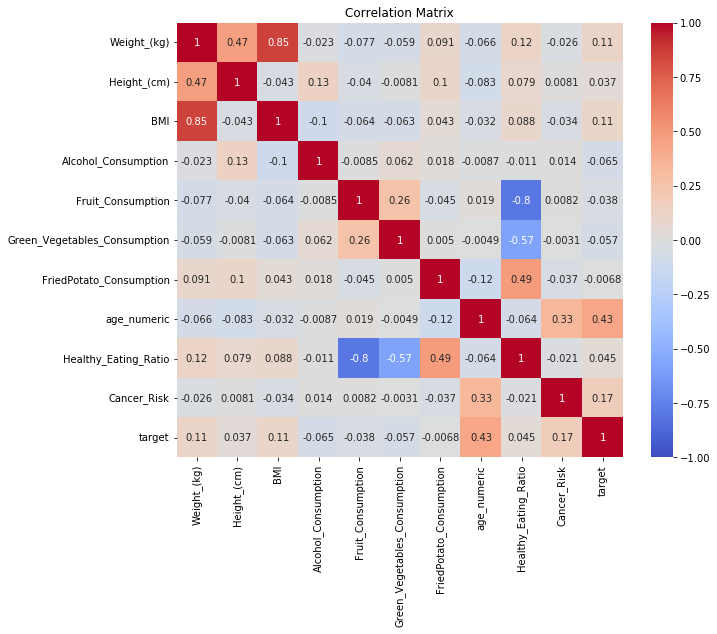

In [19]:

if isinstance(X_train_full, np.ndarray):
    X_train_full = pd.DataFrame(X_train_full, columns=[f"Feature_{i}" for i in range(X_train_full.shape[1])])

# Include the target variable if desired
data_with_target = X_train_full.copy()
data_with_target['target'] = y_train_full

# Compute the correlation matrix
correlation_matrix = data_with_target.corr()

# Display the correlation matrix
# print(correlation_matrix)

import seaborn as sns
import matplotlib.pyplot as plt

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title("Correlation Matrix")
plt.show()

# Preprocessor Pipeline

In [20]:
numerical_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(sparse=False, handle_unknown='ignore'))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_data),
        ("cat", categorical_transformer, categorical_data)
    ]
)


preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['Weight_(kg)', 'Height_(cm)', 'BMI',
                                  'Alcohol_Consumption', 'Fruit_Consumption',
                                  'Green_Vegetables_Consumption',
                                  'FriedPotato_Consumption', 'age_numeric',
                                  'Healthy_Eating_Ratio', 'Cancer_Risk']),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['Exercise', 'General_Health', 'Depression',
                                  'Diabetes', 'Arthritis', 'Sex',
                                  'Smoking_History', 'BMI_Category'])])

# Applying Preprocessor to Training and Test data

In [21]:
X_train_full_transformed = preprocessor.fit_transform(X_train_full)
X_test_transformed = preprocessor.fit_transform(X_test)
X_train_full_transformed


array([[-1.54710061, -1.01111179, -1.33510203, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.50411652,  1.5967594 , -0.29530437, ...,  0.        ,
         1.        ,  0.        ],
       [-1.86745607, -1.75621784, -1.46718859, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.13659439, -0.07972922, -0.10638987, ...,  0.        ,
         1.        ,  0.        ],
       [-1.29081625, -1.94249436, -0.52722379, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.20496106,  1.13106812, -0.35366819, ...,  0.        ,
         1.        ,  0.        ]])

# Appying SMOTE - when no undersampling is done

In [22]:
# from imblearn.over_sampling import SMOTE

# smote = SMOTE()

# X_train_full_transformed, y_train_full = smote.fit_resample(X_train_full_transformed, y_train_full)

# X_train_full_transformed.shape

# Neural Network Model

In [72]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model = Sequential([
    Dense(90, activation='selu', kernel_regularizer='l2'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(40, activation='relu', kernel_regularizer='l2'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

optimizer = Nadam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tfa.metrics.F1Score(num_classes=1, threshold=0.5)
    ]
)

In [75]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 90)                3060      
_________________________________________________________________
batch_normalization_24 (Batc (None, 90)                360       
_________________________________________________________________
dropout_32 (Dropout)         (None, 90)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 40)                3640      
_________________________________________________________________
batch_normalization_25 (Batc (None, 40)                160       
_________________________________________________________________
dropout_33 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_54 (Dense)             (None, 1)               

# K-fold Cross Validation

In [73]:
# # Neural network - K-fold Cross Validation


# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import accuracy_score
# from sklearn.neural_network import MLPClassifier
# import numpy as np

# # Define the number of folds
# n_splits = 5  
# skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# # Initialize lists to store scores
# cv_scores = []

# # Perform k-fold cross-validation
# for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_full, y_train_full)):
#     print(f'Fold {fold + 1}/{n_splits}')
    
#     # Split data into training and validation sets for this fold
#     X_train = X_train_full.iloc[train_idx]
#     y_train = y_train_full.iloc[train_idx]
#     X_val = X_train_full.iloc[val_idx]
#     y_val = y_train_full.iloc[val_idx]
    
#     # Apply preprocessing
#     X_train_transformed = preprocessor.fit_transform(X_train)
#     X_val_transformed = preprocessor.transform(X_val)
    
#     # Initialize your neural network model
# #     model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=200, random_state=42)  # Adjust parameters as needed
    
#     # Train the model
#     model.fit(
#         X_train_full_transformed, y_train_full,
#         epochs=100,
#         batch_size=32,
#         validation_split=0.2,
#         callbacks=[early_stopping],
#         verbose=1,
#     )
    
#     # Predict on validation set
#     y_pred = model.predict(X_val_transformed)
    
#     # Initialize an empty list for binary predictions
#     y_pred_binary = []

#     # Loop over the indices of y_pred
#     for i in range(0, len(y_pred)):
#         if y_pred[i] > 0.5:
#             y_pred_binary.append(1)
#         else:
#             y_pred_binary.append(0)
            
#     # Calculate score (e.g., accuracy)
#     score = accuracy_score(y_val, y_pred_binary)
#     cv_scores.append(score)
#     print(f'Fold {fold + 1} Accuracy: {score:.4f}')

# # Compute and print average score
# mean_score = np.mean(cv_scores)
# std_score = np.std(cv_scores)
# print(f'\nMean CV Accuracy: {mean_score:.4f} ± {std_score:.4f}')

In [74]:
history = model.fit(
    X_train_full_transformed, y_train_full,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1,
)

y_pred = model.predict(X_test_transformed)
import numpy as np

# Initialize an empty list for binary predictions
y_pred_binary = []

# Loop over the indices of y_pred
for i in range(0, len(y_pred)):
    if y_pred[i] > 0.5:
        y_pred_binary.append(1)
    else:
        y_pred_binary.append(0)

# Convert to a NumPy array
y_pred_binary = np.array(y_pred_binary)

# Check the shape
print(f"Shape of y_pred_binary: {y_pred_binary.shape}")
# Now you can compute metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)


print(f"Model Test Accuracy: {accuracy:.4f}")
print(f"Model Test Precision Score: {precision:.4f}")
print(f"Model Test Recall: {recall:.4f}")
print(f"Model Test F1 Score: {f1:.4f}")


Epoch 1/100
999/999 [==============================] - 5s 3ms/step - loss: 1.5342 - accuracy: 0.6711 - precision: 0.6634 - recall: 0.6947 - f1_score: 0.6787 - val_loss: 1.2993 - val_accuracy: 0.7345 - val_precision: 0.7178 - val_recall: 0.7731 - val_f1_score: 0.7444
Epoch 2/100
999/999 [==============================] - 3s 3ms/step - loss: 1.2480 - accuracy: 0.7111 - precision: 0.6958 - recall: 0.7499 - f1_score: 0.7219 - val_loss: 1.1004 - val_accuracy: 0.7445 - val_precision: 0.7278 - val_recall: 0.7813 - val_f1_score: 0.7536
Epoch 3/100
999/999 [==============================] - 3s 3ms/step - loss: 1.0725 - accuracy: 0.7190 - precision: 0.7031 - recall: 0.7581 - f1_score: 0.7296 - val_loss: 0.9588 - val_accuracy: 0.7478 - val_precision: 0.7288 - val_recall: 0.7898 - val_f1_score: 0.7581
Epoch 4/100
999/999 [==============================] - 3s 3ms/step - loss: 0.9393 - accuracy: 0.7248 - precision: 0.7071 - recall: 0.7676 - f1_score: 0.7361 - val_loss: 0.8556 - val_accuracy: 0.7517 

# Neural Network - Grid Search for tuning hyperparameters - not able to do due to prolonged process and timeout issue in lab

In [26]:
# import numpy as np
# from scikeras.wrappers import KerasClassifier
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.optimizers import Adam
# from sklearn.model_selection import GridSearchCV

# # Define the model building function with flexible hyperparameters
# def build_model(n_hidden=2, n_neurons=100, dropout_rate=0.0, learning_rate=0.0001):
#     model = Sequential()
#     # First hidden layer with batch normalization
#     model.add(Dense(n_neurons, activation='relu', kernel_regularizer='l2', input_shape=(X_train_full_transformed.shape[1],)))
#     model.add(BatchNormalization())
#     # Additional hidden layers with optional dropout
#     for i in range(n_hidden - 1):
#         neurons = n_neurons // (2 ** i)  # Decrease neurons in deeper layers
#         model.add(Dense(neurons, activation='relu', kernel_regularizer='l2'))
#         if dropout_rate > 0:
#             model.add(Dropout(dropout_rate))
#     # Output layer for binary classification
#     model.add(Dense(1, activation='sigmoid'))
    
#     # Compile the model
#     optimizer = Adam(learning_rate=learning_rate)
#     model.compile(
#         optimizer=optimizer,
#         loss='binary_crossentropy',
#         metrics=['accuracy']  # GridSearchCV scoring uses this; additional metrics can be evaluated later
#     )
#     return model

# # Define early stopping callback
# early_stopping = EarlyStopping(
#     monitor='val_accuracy',
#     patience=5,
#     restore_best_weights=True,
#     verbose=1
# )

# # Create the KerasClassifier for scikit-learn compatibility
# model = KerasClassifier(
#     model=build_model,
#     epochs=100,
#     batch_size=32,
#     validation_split=0.2,
#     callbacks=[early_stopping],
#     verbose=1
# )

# # Define the hyperparameter grid to explore
# param_grid = {
#     'model__n_hidden': [1, 2, 3],              # Number of hidden layers
#     'model__n_neurons': [25, 50, 100, 150,200],       # Neurons in the first hidden layer
#     'model__dropout_rate': [0.3, 0.5, 0.7],   # Dropout rate after hidden layers
#     'model__learning_rate': [0.001, 0.0001, 0.00001]   # Learning rate for Adam optimizer
# }

# # Configure GridSearchCV without cross-validation
# grid_search = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     cv=None,                                   # Disable cross-validation
#     scoring='accuracy',                        # Optimize for accuracy as per your goal
#     verbose=2,
#     n_jobs=-1                                  # Use all available CPU cores to speed up
# )

# # Fit the grid search (replace X_train_full_transformed and y_train_full with your data)
# grid_search.fit(X_train_full_transformed, y_train_full)

# # Output the best parameters and score
# print("Best parameters:", grid_search.best_params_)
# print("Best cross-validation accuracy:", grid_search.best_score_)

# # Optional: Use the best model for further evaluation or prediction
# best_model = grid_search.best_estimator_
# # You can predict with: best_model.predict(X_test_transformed)

# Logistic Regression - GridSearchCV, fit( ), save and load model

In [38]:
# Grid search for Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the model
lr_model = LogisticRegression(random_state=42)

# Define the hyperparameter grid
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'penalty': ['l1', 'l2'],         # Regularization type
    'solver': ['liblinear'],         # Solver compatible with l1 and l2
    'max_iter': [100, 200, 300, 400, 500]           # Maximum iterations
}

# Set up GridSearchCV without cross-validation
grid_search_lr = GridSearchCV(
    estimator=lr_model,
    param_grid=param_grid_lr,
    cv=None,  # No cross-validation
    scoring='accuracy',
    n_jobs=-1
)

# Fit the model
grid_search_lr.fit(X_train_full_transformed, y_train_full)

# Print the best parameters and score
print("Logistic Regression - Best Parameters:", grid_search_lr.best_params_)
print("Logistic Regression - Best Score:", grid_search_lr.best_score_)

# Best model
best_lr_model = grid_search_lr.best_estimator_

Logistic Regression - Best Parameters: {'C': 0.1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression - Best Score: 0.7553625175005235


In [55]:
# Logistic Regression
# from sklearn.linear_model import LogisticRegression

# lr_model = LogisticRegression(max_iter=100, random_state=42)  # max_iter increased for convergence
best_lr_model.fit(X_train_full_transformed, y_train_full)


In [92]:

# joblib.dump(best_lr_model, 'logisticregression_model.joblib')

lr_loaded_model = joblib.load('logisticregression_model.joblib')
model = lr_loaded_model

model

LogisticRegression(C=0.1, penalty='l1', random_state=42, solver='liblinear')

# Decision Tree Classifier - GridSearchCV, fit( ), save and load model

In [78]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define the model
dt_model = DecisionTreeClassifier(random_state=42)

# Define the hyperparameter grid
param_grid_dt = {
    'max_depth': [8,9,10],             # Maximum depth
    'min_samples_split': [3,4,5,6,7,8,9,10],           # Minimum samples to split
    'min_samples_leaf': [1, 2,3, 4,5],             # Minimum samples at a leaf
    'criterion': ['gini']           # Splitting criterion
}

# Set up GridSearchCV without cross-validation
grid_search_dt = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid_dt,
    cv=5,  # No cross-validation
    scoring='accuracy',
    n_jobs=-1
)

# Fit the model
grid_search_dt.fit(X_train_full_transformed, y_train_full)

# Print the best parameters and score
print("Decision Tree - Best Parameters:", grid_search_dt.best_params_)
print("Decision Tree - Best Score:", grid_search_dt.best_score_)

# Best model
best_dt_model = grid_search_dt.best_estimator_

Decision Tree - Best Parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 6}
Decision Tree - Best Score: 0.745626122880105


In [79]:
best_dt_model.fit(X_train_full_transformed, y_train_full)


In [114]:

# joblib.dump(best_dt_model, 'decisiontree_model.joblib')

dt_loaded_model = joblib.load('decisiontree_model.joblib')
model = dt_loaded_model

model

DecisionTreeClassifier(max_depth=8, min_samples_leaf=2, min_samples_split=6,
                       random_state=42)

# RandomForest Classifier - GridSearchCV, fit( ), save and load model

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the model
rf_model = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid
param_grid_rf = {
    'n_estimators': [100, 200,300,400],            # Number of trees
    'max_depth': [6,7,8,9],             # Maximum depth
    'min_samples_split': [5,6,7,8],           # Minimum samples to split
    'min_samples_leaf': [1, 2,3, 4],             # Minimum samples at a leaf
    'criterion': ['gini','entropy']           # Splitting criterion
}

# Set up GridSearchCV without cross-validation
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    cv=None,  # No cross-validation
    scoring='accuracy',
    n_jobs=-1
)

# Fit the model
grid_search_rf.fit(X_train_full_transformed, y_train_full)

# Print the best parameters and score
print("Random Forest - Best Parameters:", grid_search_rf.best_params_)
print("Random Forest - Best Score:", grid_search_rf.best_score_)

# Best model
best_rf_model = grid_search_rf.best_estimator_

Random Forest - Best Parameters: {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 100}
Random Forest - Best Score: 0.752909639113715


In [59]:
best_rf_model.fit(X_train_full_transformed, y_train_full)


In [97]:

# joblib.dump(best_rf_model, 'randomforest_model.joblib')

rf_loaded_model = joblib.load('randomforest_model.joblib')
model = rf_loaded_model

model

RandomForestClassifier(max_depth=9, min_samples_split=7, random_state=42)

# Ensemble Learning - Using best estimators of above 3 models

In [107]:
# Ensemble Learning
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ('lr', best_lr_model),
        ('dt', best_dt_model),
        ('rf', best_rf_model)
    ],
    voting='soft'
)
voting_clf.fit(X_train_full_transformed, y_train_full)


VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.1, penalty='l1',
                                                 random_state=42,
                                                 solver='liblinear')),
                             ('dt',
                              DecisionTreeClassifier(max_depth=8,
                                                     min_samples_leaf=2,
                                                     min_samples_split=6,
                                                     random_state=42)),
                             ('rf',
                              RandomForestClassifier(max_depth=9,
                                                     min_samples_split=7,
                                                     random_state=42))],
                 voting='soft')

In [108]:

# joblib.dump(voting_clf, 'ensemble_model.joblib')

ensemble_loaded_model = joblib.load('ensemble_model.joblib')
model = voting_clf

ensemble_loaded_model

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.1, penalty='l1',
                                                 random_state=42,
                                                 solver='liblinear')),
                             ('dt',
                              DecisionTreeClassifier(max_depth=8,
                                                     min_samples_leaf=2,
                                                     min_samples_split=6,
                                                     random_state=42)),
                             ('rf',
                              RandomForestClassifier(max_depth=9,
                                                     min_samples_split=7,
                                                     random_state=42))],
                 voting='soft')

# Verify which model is currently chosen


In [124]:
model

# Target prediction on test data

In [125]:
y_pred = model.predict(X_test_transformed)

# Converting predicted value to 0 and 1

In [126]:

import numpy as np

# Initialize an empty list for binary predictions
y_pred_binary = []

# Loop over the indices of y_pred
for i in range(0, len(y_pred)):
    if y_pred[i] > 0.5:
        y_pred_binary.append(1)
    else:
        y_pred_binary.append(0)

# Convert to a NumPy array
y_pred_binary = np.array(y_pred_binary)

# Check the shape
print(f"Shape of y_pred_binary: {y_pred_binary.shape}")

Shape of y_pred_binary: (9989,)


# Calculating metrics on Test data - Accuracy, Precision, Recall, F1 Score

In [127]:

# Now you can compute metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)


print(f"Model Test Accuracy: {accuracy:.4f}")
print(f"Model Test Precision Score: {precision:.4f}")
print(f"Model Test Recall: {recall:.4f}")
print(f"Model Test F1 Score: {f1:.4f}")


Model Test Accuracy: 0.7526
Model Test Precision Score: 0.7290
Model Test Recall: 0.8042
Model Test F1 Score: 0.7647


# Plots to checkout while training

In [120]:
# Training vs Validation Plots

# Extract training and validation metrics from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Create subplots for loss and accuracy
plt.figure(figsize=(12, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy', color='blue')
plt.plot(val_acc, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

NameError: name 'history' is not defined

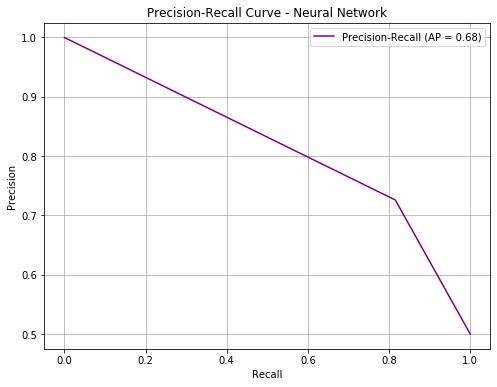

In [36]:
# Precision-Recall curve
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_pred_binary)
avg_precision = average_precision_score(y_test, y_pred_binary)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', label=f'Precision-Recall (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Neural Network')
plt.legend()
plt.grid(True)

Text(0.5, 1.0, 'Confusion Matrix - Neural Network')

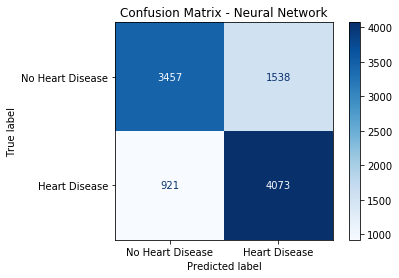

In [37]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Heart Disease', 'Heart Disease'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Neural Network')

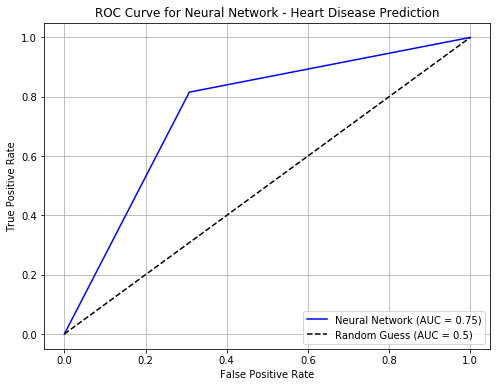

In [38]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Neural Network (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Neural Network - Heart Disease Prediction')
plt.legend(loc='lower right')
plt.grid(True)